In [1]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt

import utils.compressed_sensing as cs
import torch.nn as nn
import torch

import os
import torch.nn.functional as F

# mridata.org Example

In [2]:
cardiac = scio.loadmat('data/cardiac.mat')['seq']
lustig_knee_p2 = scio.loadmat('data/lustig_knee_p2.mat')['xn']

print(cardiac.shape)
print(lustig_knee_p2.shape)

(256, 256, 30)
(128, 128, 128, 2)


(256, 128, 128) (256, 128, 128) (256, 128, 128)


Text(0.5, 1.0, 'Test')

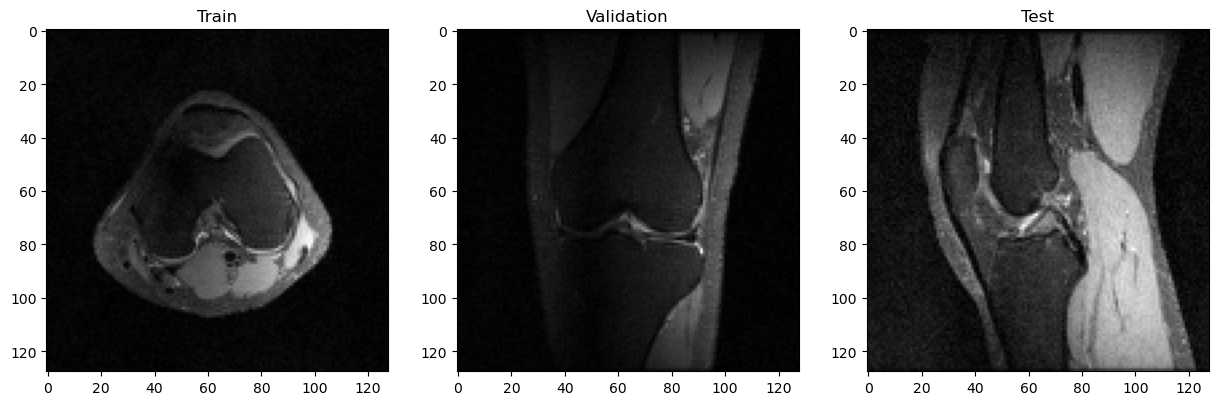

In [3]:
def create_dummy_data():
    """
    Creates dummy dataset from one knee subject for demo.
    In practice, one should take much bigger dataset,
    as well as train & test should have similar distribution.

    Source: http://mridata.org/
    """
    data = scio.loadmat('data/lustig_knee_p2.mat')['xn']
    nx, ny, nz, nc = data.shape

    train = np.transpose(data, (3, 0, 1, 2)).reshape((-1, ny, nz))
    validate = np.transpose(data, (3, 1, 0, 2)).reshape((-1, nx, nz))
    test = np.transpose(data, (3, 2, 0, 1)).reshape((-1, nx, ny))

    return train, validate, test

train, validate, test = create_dummy_data()
print(train.shape, validate.shape, test.shape)
#plt.imshow(train[0], cmap='gray')
idx = 190
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.abs(train[idx]), cmap='gray')
ax[0].set_title('Train')
ax[1].imshow(np.abs(validate[idx]), cmap='gray')
ax[1].set_title('Validation')
ax[2].imshow(np.abs(test[idx]), cmap='gray')
ax[2].set_title('Test')

(1, 256, 256)
64.47228916266386


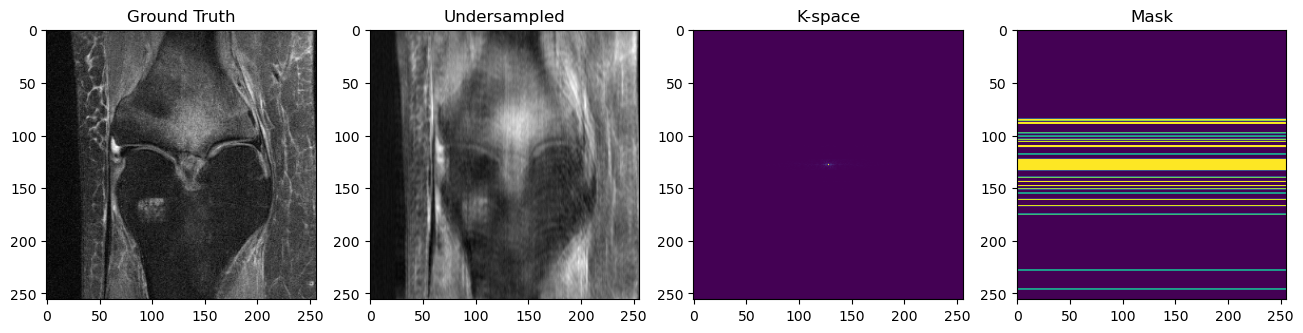

In [4]:
dataset = scio.loadmat('data/knee/knee_singlecoil_train.mat')
images = dataset['images']
k_spaces = dataset['k_space']

image = images[:1]
print(image.shape)

mask = cs.cartesian_mask(image.shape, acc=8, centred=True)
im_und, k_und = cs.undersample(image, mask, centred=True)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(np.abs(image[0]), cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(np.abs(im_und[0]), cmap='gray')
ax[1].set_title('Undersampled')
ax[2].imshow(np.abs(k_und[0]))
ax[2].set_title('K-space')
ax[3].imshow(mask[0])
ax[3].set_title('Mask')

print(np.abs(k_und).max())

(1, 256, 256)


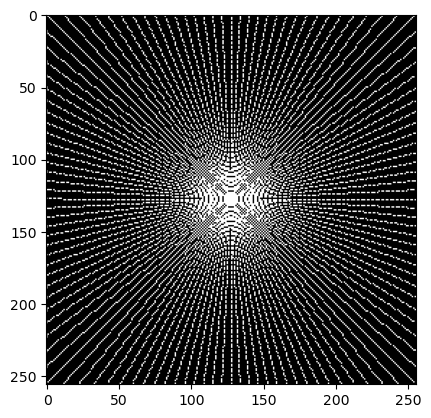

In [14]:
# Example usage
shape = (1, 256, 256)
acc = 4
mask = cs.radial_mask(shape, acc, sample_n=0, centred=True)
print(mask.shape)
plt.imshow(mask.squeeze(), cmap='gray')


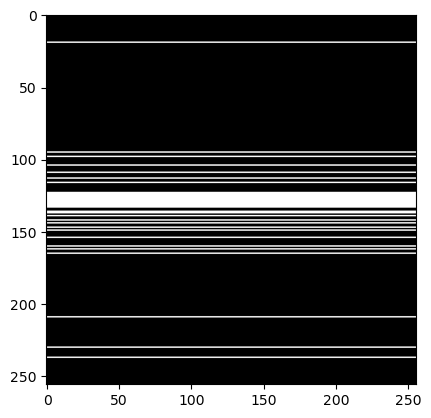

In [11]:
mask = cs.cartesian_mask(image.shape, acc=8, centred=True, sample_n=10)
plt.imshow(mask[0], cmap='gray')

torch.Size([5, 1, 256, 256]) torch.Size([5, 1, 256, 256]) torch.Size([5, 1, 256, 256]) torch.Size([5, 1, 256, 256]) torch.Size([5, 1, 256, 256])
torch.complex64 torch.complex64 torch.float32 torch.complex64 torch.complex64


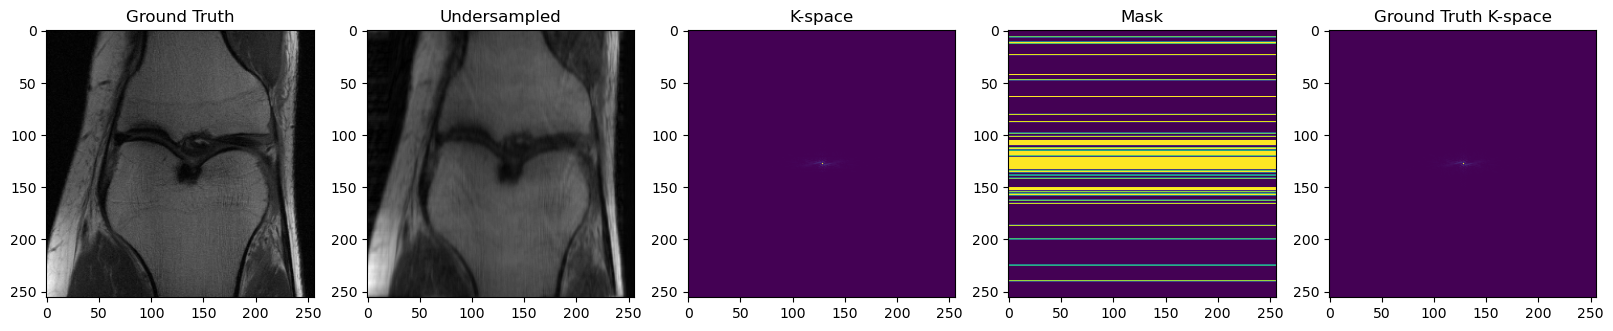

torch.Size([5, 1, 256, 256])


In [5]:
from utils.dataset import anatomy_data
from torch.utils.data import DataLoader

knee_dataset = anatomy_data('data/knee/knee_singlecoil_train.mat', 5)
knee_loader = DataLoader(knee_dataset, batch_size=5, shuffle=True)

idx = 0

for i, data in enumerate(knee_loader):
    im_und, k_und, mask, img_gnd, k_gnd = data
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    ax[0].imshow(np.abs(img_gnd[idx, 0]), cmap='gray')
    ax[0].set_title('Ground Truth')
    ax[1].imshow(np.abs(im_und[idx, 0]), cmap='gray')
    ax[1].set_title('Undersampled')
    ax[2].imshow(np.abs(k_und[idx, 0]))
    ax[2].set_title('K-space')
    ax[3].imshow(mask[idx, 0])
    ax[3].set_title('Mask')
    ax[4].imshow(np.abs(k_gnd[idx, 0]))
    ax[4].set_title('Ground Truth K-space')
    
    print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
    print(im_und.dtype, k_und.dtype, mask.dtype, img_gnd.dtype, k_gnd.dtype)
    break

plt.show()
k_torch = torch.fft.fft2(im_und, norm='ortho')
print(k_torch.shape)

## Knee MRI ifft2 test example

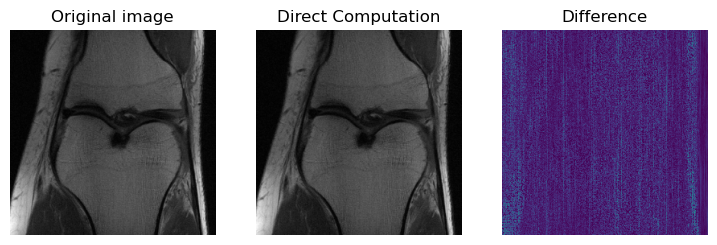

In [6]:
from utils import mymath

img = img_gnd[0, 0].numpy()
k = k_gnd[0, 0].numpy()

k_CD = mymath.fft2c(img)
img_torch = torch.fft.ifft2(k_gnd[:1], norm='ortho')
img_DC = torch.fft.ifft2(torch.from_numpy(k_CD).unsqueeze(0).unsqueeze(0), norm='ortho')

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(torch.abs(img_torch[0, 0]).numpy(), cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(np.abs(img_DC.numpy()[0, 0]), cmap='gray')
ax[1].set_title('Direct Computation')
ax[2].imshow(np.abs(img_DC.numpy()[0, 0] - img_torch[0, 0].numpy()))
ax[2].set_title('Difference')

# remove figure axis
for a in ax:
    a.axis('off')
    
plt.show()

# FastMRI Brain Data Example

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
(16, 16, 768, 396) (16, 384, 384)


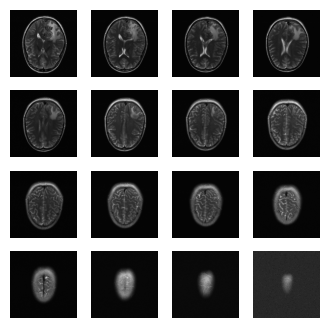

In [34]:
import h5py

test_brain = h5py.File('data/brain/multicoil_train/file_brain_AXT2_210_6001534.h5', 'r')
print(test_brain.keys())

kspace = test_brain['kspace']
recon = test_brain['reconstruction_rss']

print(kspace.shape, recon.shape)
#plt.imshow(np.abs(recon[-1]), cmap='gray')


fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        img = recon[i*4+j]
        ax[i, j].imshow(np.abs(img), cmap='gray')
        ax[i, j].axis('off')
plt.show()

# Network Training

In [7]:
def lrelu():
    return nn.LeakyReLU(0.01, inplace=True)


def relu():
    return nn.ReLU(inplace=True)
    

def data_consistency(k, k0, mask, noise_lvl=None):
    """
    k    - input in k-space
    k0   - initially sampled elements in k-space
    mask - corresponding nonzero location
    """
    v = noise_lvl
    if v:  # noisy case
        out = (1 - mask) * k + mask * (k + v * k0) / (1 + v)
    else:  # noiseless case
        out = (1 - mask) * k + mask * k0
    return out

class conv_block(nn.Module):
    
    def __init__(self, n_ch, nd, nf=32, ks=3):
        super(conv_block, self).__init__()
        conv_1 = nn.Conv2d(n_ch, nf, ks, stride=1, padding=1, bias=True).to(torch.complex64)
        conv_n = nn.Conv2d(nf, n_ch, ks, stride=1, padding=1, bias=True).to(torch.complex64)
        
        self.layers = []
        self.layers.append(conv_1)
        for i in range(nd-2):
            self.layers.append(nn.Conv2d(nf, nf, ks, stride=1, padding=1, bias=True).to(torch.complex64))
            
        self.layers.append(conv_n)
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = F.relu(x.real) + 1j * F.relu(x.imag)
        x = self.layers[-1](x)
        return x
    

class DataConsistencyInKspace(nn.Module):
    """ Create data consistency operator

    Warning: note that FFT2 (by the default of torch.fft) is applied to the last 2 axes of the input.
    This method detects if the input tensor is 4-dim (2D data) or 5-dim (3D data)
    and applies FFT2 to the (nx, ny) axis.

    """

    def __init__(self, noise_lvl=None, norm='ortho'):
        super(DataConsistencyInKspace, self).__init__()
        self.normalized = norm
        self.noise_lvl = noise_lvl

    def forward(self, *input, **kwargs):
        return self.perform(*input)

    def perform(self, x, k0, mask):
        """
        x    - input in image domain, of shape (n, 2, nx, ny[, nt])
        k0   - initially sampled elements in k-space
        mask - corresponding nonzero location
        """

        k = torch.fft.fft2(x, norm=self.normalized)
        out = data_consistency(k, k0, mask, self.noise_lvl)
        x_res = torch.fft.ifft2(out, norm=self.normalized)

        return x_res

class DnCn(nn.Module):
    def __init__(self, n_channels=1, nc=5, nd=5, **kwargs):
        super(DnCn, self).__init__()
        self.nc = nc
        self.nd = nd
        print('Creating D{}C{}'.format(nd, nc))
        conv_blocks = []
        dcs = []

        for i in range(nc):
            conv_blocks.append(conv_block(n_channels, nd))
            dcs.append(DataConsistencyInKspace(norm='ortho'))

        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.dcs = dcs

    def forward(self, x, k, m):
        for i in range(self.nc):
            x_cnn = self.conv_blocks[i](x)
            x = x + x_cnn
            x = self.dcs[i].perform(x, k, m)

        return x

#net.conv_blocks[0][0].weight


In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

model = DnCn(1,5,5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8
model.to(device)

knee_dataset = anatomy_data('data/knee/knee_singlecoil_train.mat', acc=5)
knee_loader = DataLoader(knee_dataset, batch_size=batch_size, shuffle=True)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.9)
save_dir = "universal_MRI/knee/checkpoints"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


for epoch in range(1, 101):
    PSNR_list, SSIM_list, LOSS_list = [], [], []
    for i, data in enumerate(knee_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)
        
        # forward pass
        optim.zero_grad()
        x_output = model(im_und, k_und, mask)
        x_output = torch.abs(x_output).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        
        loss = torch.sum(torch.square(x_output - img_gnd))#F.mse_loss(x_output.real, img_gnd.real) + F.mse_loss(x_output.imag, img_gnd.imag)
        loss.backward()
        optim.step()
        
        LOSS_list.append(loss.item())
        if i % 10 == 0:
            p, s = 0, 0
            for j in range(batch_size):
                output = np.abs(x_output[j].detach().cpu().numpy().squeeze()).clip(0,1)
                label = np.abs(img_gnd[j].detach().cpu().numpy().squeeze())
                p += psnr(output.astype(label.dtype), label, data_range=1.0)
                s += ssim(output.astype(label.dtype), label, data_range=1.0)
            p /= batch_size
            s /= batch_size
            PSNR_list.append(p)
            SSIM_list.append(s)
            print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}, PSNR: {p}, SSIM: {s}')
        
    print(f'Epoch: {epoch}, Loss: {np.mean(LOSS_list)}, PSNR: {np.mean(PSNR_list)}, SSIM: {np.mean(SSIM_list)}\n')
    scheduler.step()
    if epoch % 10 == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'checkpoint.pth'))

Creating D5C5


/home/dingchi/Apps/anaconda3/envs/universe/lib/python3.11/site-packages/torch/nn/modules/module.py:1148: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


Epoch: 1, Iteration: 0, Loss: 1106.5810546875, PSNR: 26.95315620433998, SSIM: 0.6472691595225386
Epoch: 1, Iteration: 10, Loss: 787.3696899414062, PSNR: 28.83947536249986, SSIM: 0.7201669618809657
Epoch: 1, Iteration: 20, Loss: 907.2488403320312, PSNR: 27.78173753812235, SSIM: 0.6798401346797236
Epoch: 1, Iteration: 30, Loss: 905.1799926757812, PSNR: 27.986730698678613, SSIM: 0.7238517340407495
Epoch: 1, Iteration: 40, Loss: 910.2744140625, PSNR: 27.84594485331775, SSIM: 0.6845497753632394
Epoch: 1, Iteration: 50, Loss: 650.23291015625, PSNR: 29.468929759762705, SSIM: 0.7539081992967172
Epoch: 1, Iteration: 60, Loss: 714.7763671875, PSNR: 29.022560890484474, SSIM: 0.696506719494081
Epoch: 1, Iteration: 70, Loss: 694.5224609375, PSNR: 29.288960460780846, SSIM: 0.7544959017095284
Epoch: 1, Iteration: 80, Loss: 581.8924560546875, PSNR: 29.75730816083071, SSIM: 0.7457668868293883
Epoch: 1, Iteration: 90, Loss: 726.5968017578125, PSNR: 29.34676351090186, SSIM: 0.7169029202553071
Epoch: 1, L

KeyboardInterrupt: 

Text(0.5, 1.0, 'Ground Truth')

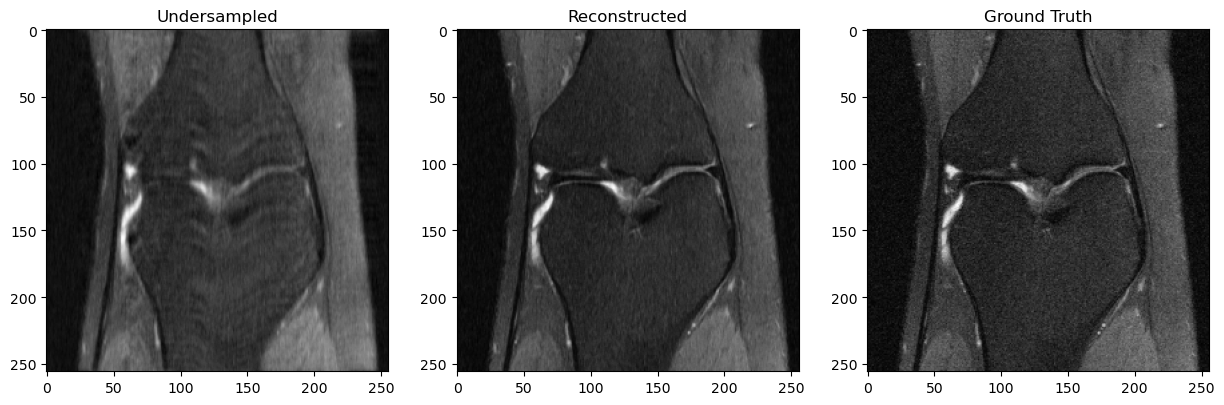

In [21]:
idx = 4
out_img = x_output[idx].detach().cpu().numpy().squeeze()
inp_img = im_und[idx].detach().cpu().numpy().squeeze()
gnd_img = img_gnd[idx].detach().cpu().numpy().squeeze()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(np.abs(inp_img), cmap='gray')
ax[0].set_title('Undersampled')
ax[1].imshow(np.abs(out_img), cmap='gray')
ax[1].set_title('Reconstructed')
ax[2].imshow(np.abs(gnd_img), cmap='gray')
ax[2].set_title('Ground Truth')

In [29]:
print(np.abs(inp_img).max(), np.abs(inp_img).min())
print(np.abs(out_img).max(), np.abs(out_img).min())
print(np.abs(gnd_img).max(), np.abs(gnd_img).min())

0.9901785 0.000549046
0.9276598 0.0
1.0 0.0


# MRI Brain Dataset

In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

model = DnCn(1,5,5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8
model.to(device)

brain_dataset = anatomy_data('data/brain/brain_singlecoil_train.mat', acc=5)
brain_loader = DataLoader(brain_dataset, batch_size=batch_size, shuffle=True)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.9)
save_dir = "universal_MRI/brain/checkpoints"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


for epoch in range(1, 101):
    PSNR_list, SSIM_list, LOSS_list = [], [], []
    for i, data in enumerate(brain_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)
        
        # forward pass
        optim.zero_grad()
        x_output = model(im_und, k_und, mask)
        x_output = torch.abs(x_output).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        
        loss = torch.sum(torch.square(x_output - img_gnd))#F.mse_loss(x_output.real, img_gnd.real) + F.mse_loss(x_output.imag, img_gnd.imag)
        loss.backward()
        optim.step()
        
        LOSS_list.append(loss.item())
        if i % 10 == 0:
            p, s = 0, 0
            for j in range(batch_size):
                output = np.abs(x_output[j].detach().cpu().numpy().squeeze()).clip(0,1)
                label = np.abs(img_gnd[j].detach().cpu().numpy().squeeze())
                p += psnr(output.astype(label.dtype), label, data_range=1.0)
                s += ssim(output.astype(label.dtype), label, data_range=1.0)
            p /= batch_size
            s /= batch_size
            PSNR_list.append(p)
            SSIM_list.append(s)
            print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}, PSNR: {p}, SSIM: {s}')
        
    print(f'Epoch: {epoch}, Loss: {np.mean(LOSS_list)}, PSNR: {np.mean(PSNR_list)}, SSIM: {np.mean(SSIM_list)}\n')
    scheduler.step()
    if epoch % 10 == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'checkpoint.pth'))

Creating D5C5


/home/dingchi/Apps/anaconda3/envs/universe/lib/python3.11/site-packages/torch/nn/modules/module.py:1148: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


Epoch: 1, Iteration: 0, Loss: 2010.5675048828125, PSNR: 24.32312488619048, SSIM: 0.5752944083044339
Epoch: 1, Iteration: 10, Loss: 2006.59619140625, PSNR: 24.438191034067437, SSIM: 0.6546178591541896
Epoch: 1, Iteration: 20, Loss: 1318.87060546875, PSNR: 26.150157145073855, SSIM: 0.7393265748929897
Epoch: 1, Iteration: 30, Loss: 1046.4825439453125, PSNR: 27.119411844963068, SSIM: 0.7710387476730003
Epoch: 1, Iteration: 40, Loss: 959.8063354492188, PSNR: 27.613910349964712, SSIM: 0.8036816211601551
Epoch: 1, Iteration: 50, Loss: 771.118896484375, PSNR: 28.897794336648975, SSIM: 0.8185749078233995
Epoch: 1, Iteration: 60, Loss: 659.8722534179688, PSNR: 29.510196458258754, SSIM: 0.847314098222893
Epoch: 1, Iteration: 70, Loss: 614.83203125, PSNR: 29.414036034632396, SSIM: 0.8359631244876717
Epoch: 1, Iteration: 80, Loss: 681.1665649414062, PSNR: 29.223562489389106, SSIM: 0.8282636043483318
Epoch: 1, Iteration: 90, Loss: 754.689697265625, PSNR: 28.639336292009002, SSIM: 0.8248003187310979


Text(0.5, 1.0, 'Ground Truth')

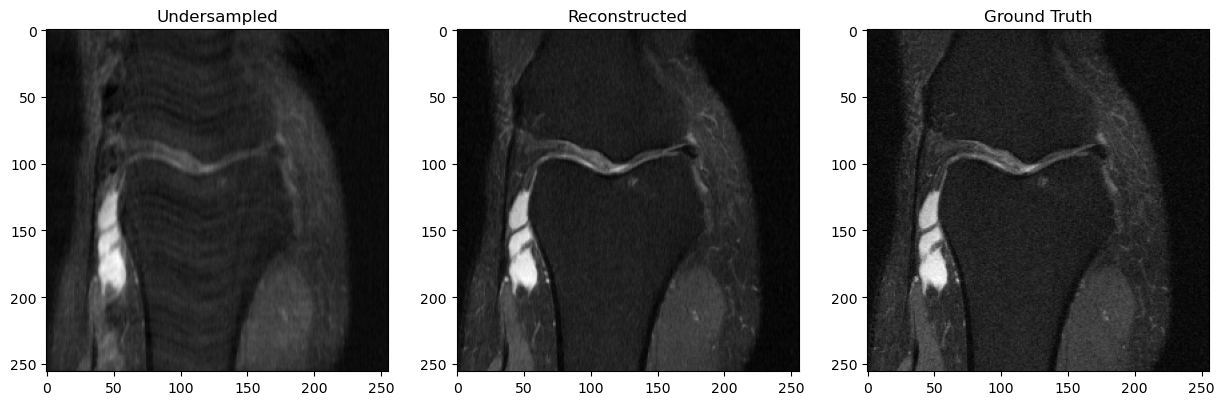

In [9]:
idx = 4
out_img = x_output[idx].detach().cpu().numpy().squeeze()
inp_img = im_und[idx].detach().cpu().numpy().squeeze()
gnd_img = img_gnd[idx].detach().cpu().numpy().squeeze()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(np.abs(inp_img), cmap='gray')
ax[0].set_title('Undersampled')
ax[1].imshow(np.abs(out_img), cmap='gray')
ax[1].set_title('Reconstructed')
ax[2].imshow(np.abs(gnd_img), cmap='gray')
ax[2].set_title('Ground Truth')